In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.optimize import curve_fit

If running on Google Colab, can use google drive for the data and mount the drive. Note this example assumes the file is in the same directly as the notebook default "Colab Notebooks", if you are working in a different directory you will need to adjust the path accordingly.

Check the name of the input file. This code expects the format from the oscilloscope, note that the first 25 lines need to be skipped to get to the data of interest.

In [2]:
mydata1 =np.loadtxt(fname="./CSV/ALL0002.CSV",delimiter=',',skiprows=25,usecols=(0,1,2,3))
mydata2 =np.loadtxt(fname="./CSV/ALL0003.CSV",delimiter=',',skiprows=25,usecols=(0,1,2,3))
mydata3 =np.loadtxt(fname="./CSV/ALL0004.CSV",delimiter=',',skiprows=25,usecols=(0,1,2,3))
mydata4 =np.loadtxt(fname="./CSV/ALL0005.CSV",delimiter=',',skiprows=25,usecols=(0,1,2,3))
mydata5 =np.loadtxt(fname="./CSV/ALL0006.CSV",delimiter=',',skiprows=25,usecols=(0,1,2,3))

mydata6 =np.loadtxt(fname="./CSV/ALL0007.CSV",delimiter=',',skiprows=25,usecols=(0,1,2,3))
mydata7 =np.loadtxt(fname="./CSV/ALL0008.CSV",delimiter=',',skiprows=25,usecols=(0,1,2,3))
mydata8 =np.loadtxt(fname="./CSV/ALL0012.CSV",delimiter=',',skiprows=25,usecols=(0,1,2,3))
mydata9 =np.loadtxt(fname="./CSV/ALL0010.CSV",delimiter=',',skiprows=25,usecols=(0,1,2,3))
mydata10 =np.loadtxt(fname="./CSV/ALL0011.CSV",delimiter=',',skiprows=25,usecols=(0,1,2,3))


mydata1 = mydata9

The data comes in 4 columns, the first (index 0) and third (index 2) columns are the time and are identical. So we use the first one for the time and then the second corresponds to the clock signal (index 1, channel 1 on the oscilloscope) and the fourth corresponds to the detector signal (index 3, channel 2 on the oscilloscope).

In [3]:
tim1 = mydata1[0:,0]
clk1 = mydata1[0:,1]
sig1 = mydata1[0:,3]

# Plot amplitude vs time

In [4]:
def plotAmplitudeVsTime(time, amplitude, color):
    plt.plot(time,amplitude,color)
    plt.title('Amplitude vs Time')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude [V]')
    plt.grid()
    plt.show()

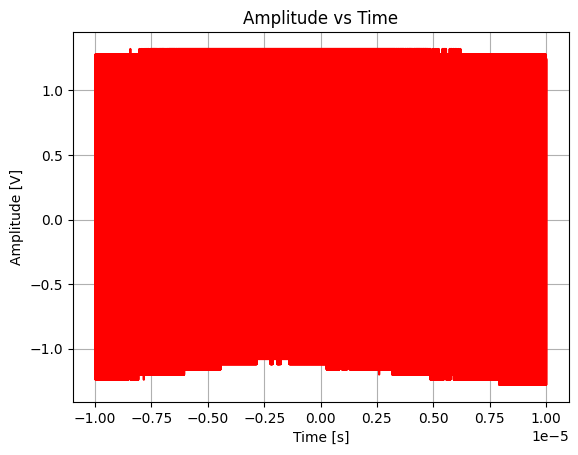

In [5]:
plotAmplitudeVsTime(tim1, clk1, 'r')
#10000 points from -10 to 10 microseconds and amplitude around 35 mV

Set the number of points to fit and where to start the fit.

In [6]:
ndatapoints=100
nstart=4950

Make new arrays with the limited range you want to fit

In [7]:
tim11 = tim1[nstart:nstart+ndatapoints-1]
clk11 = clk1[nstart:nstart+ndatapoints-1]
sig11 = sig1[nstart:nstart+ndatapoints-1]

Plot the range to fit to check and check the behavior of the clock signal over the range of points chosen

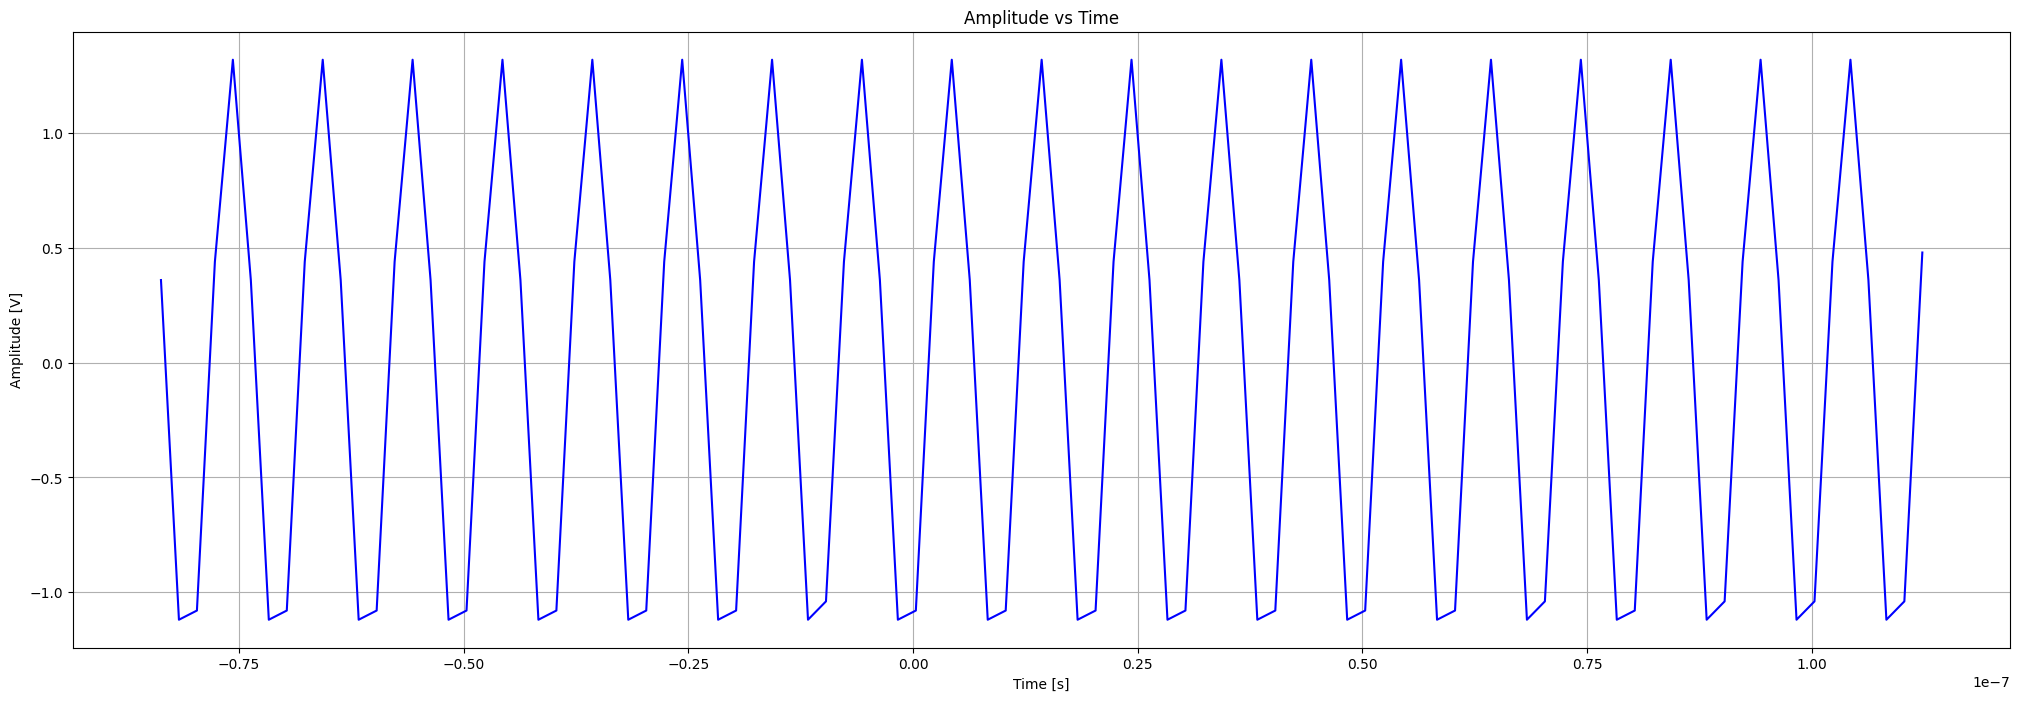

In [8]:
plt.figure(figsize=(25,8))
plotAmplitudeVsTime(tim11, clk11, 'b')

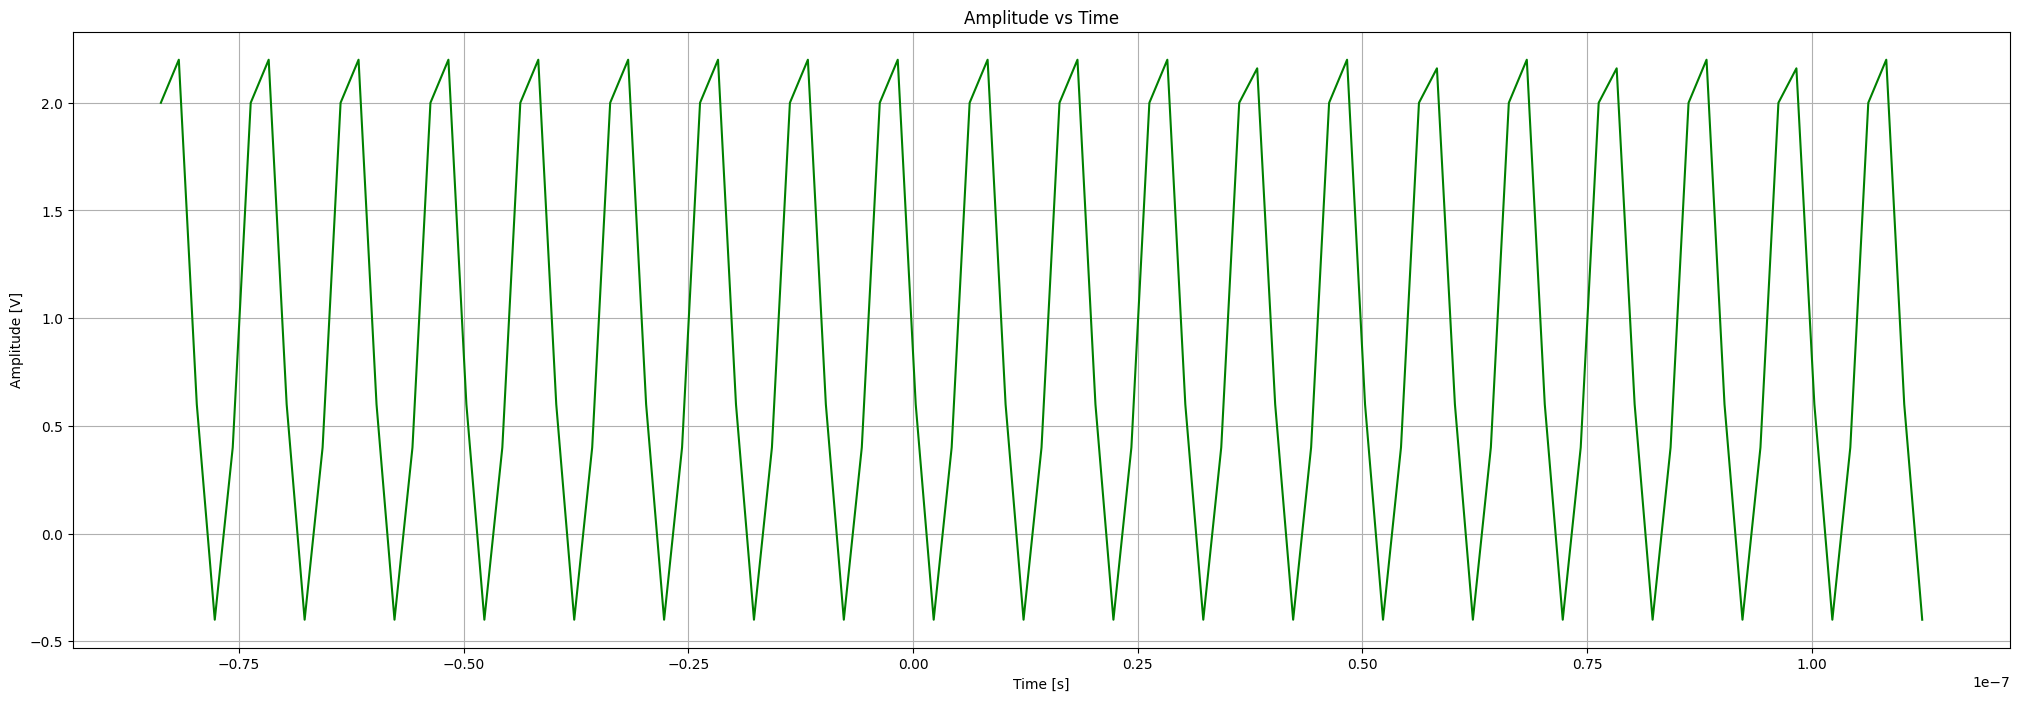

In [9]:
#check the behaviour of the detector signal over the range of points chosen
plt.figure(figsize=(25,8))
plotAmplitudeVsTime(tim11, sig11, 'g')

### Fit the curves
Define the form of the wave to be fit
$$ A\sin(\omega t - \phi) + C; \quad \omega = 2\pi\cdot f$$

In [10]:
def my_sin(x, amplitude, freq, phase, offset):
    return amplitude * np.sin(2.0 * np.pi * x * freq - phase) + offset

To perform the fit using curve_fit recall that you need to provide a guess.

The function below "my_guess" provides a guess of the parameters that you can use as input. Note that you do not need to know how it works in detail!

The input to the function is the time coordinate and the amplitude data for any of the signals.

In [11]:
fstpt=0
lstpt=9999
def my_guess(t,y):
    n = len(t)
    jj = 0                           # find t(jj) ~= 0
    for i in range(1,n-1,1):
        if (t[i]<=0.0 and t[i+1]>0.0):
            jj=i-1

    guess_out = np.zeros(4)
    guess_out[1]=100.0e6
    gmax = -9e20
    gmin = +9e20
    gave = 0.0
    flag = 0
    k = 200                         # number of points used to make guess
    for i in range(jj,jj+k-1,1):    # get offset and amplitude
        gave=gave+y[i]
        if y[i] > gmax:
            gmax = y[i]
        if y[i] < gmin:
            gmin = y[i]


    gave = gave/k
    if gave < 1e-10:
            gave = 0.0
    guess_out[3] = gave
    guess_out[0] = (gmax-gmin)/2.0
    flag = 0
    j = 0
    for i in range(jj,jj+k-1,1):    # get phase
        if ((flag == 0) and (t[i]>=0.0)):
            if ((y[i+1]-gave>0.0) and (y[i]-gave<0.0)):   # first zero crossing
               flag = 1
               j = i

    slope = (y[j+1]-y[j]) / (t[j+1]-t[j])
    t0 = t[j] - (y[j]-gave)/slope         # estimate of zero crossing time
    gphase = 2.0*np.pi*guess_out[1]*t0
    if gphase>2.0*np.pi:
        gphase=gphase-2.0*np.pi
    guess_out[2] = gphase
    return guess_out

In [12]:
guess = my_guess(tim1,clk1)
print(f'The phase guess is {guess[2]:.3f}')
clk1_guess = guess[2]

The phase guess is 1.081


#### Now use the guess above with curve_fit to extract the fit parameters for the clock signal

In [13]:
out_sine,out_cov=curve_fit(my_sin,tim11,clk11,p0=guess)
err_ampl = np.sqrt(out_cov[0,0])
err_freq = np.sqrt(out_cov[1,1])
err_phase = np.sqrt(out_cov[2,2])
err_offset = np.sqrt(out_cov[3,3])
#print(out_sine)
#print("Uncertainties:",err_ampl,err_freq,err_phase,err_offset)
phase_clk1=out_sine[2]
err_phase_clk1 = err_phase
freq=out_sine[1]
print(f'The first clock phase is {phase_clk1:.3f} +/- {err_phase_clk1:.3f}')
print(f'The frequency is {freq:.5E} +/- {err_freq:.1E}')

The first clock phase is 1.100 +/- 0.001
The frequency is 1.00008E+08 +/- 2.5E+03


Check the fit results for the clock signal

In [14]:
fitrange=np.linspace(tim11[0],tim11[-1],1000)
fitfunc=my_sin(fitrange,out_sine[0],out_sine[1],out_sine[2],out_sine[3])

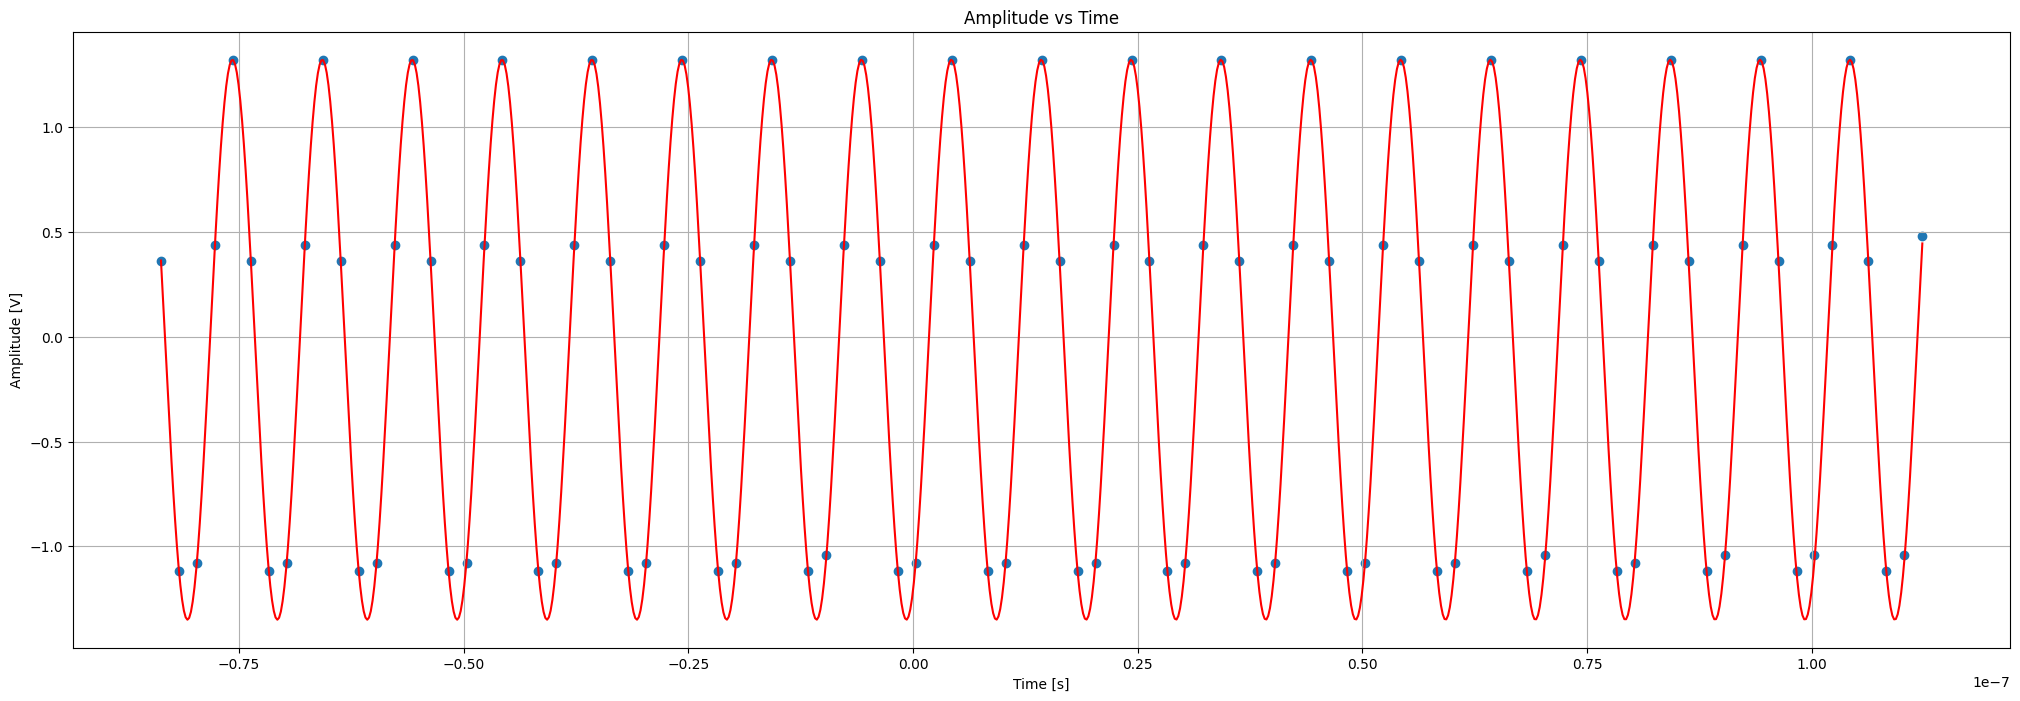

In [15]:
plt.figure(figsize=(25,8))
plt.scatter(tim11,clk11)
plotAmplitudeVsTime(fitrange, fitfunc, 'r')

Also fit the detector signal and check the result

In [16]:
guess = my_guess(tim1,sig1)
print(f'The phase guess is {guess[2]:.3f}')
sig1_guess = guess[2]

The phase guess is 3.140


In [17]:
out_sine,out_cov=curve_fit(my_sin,tim1,sig1,p0=guess)
err_ampl = np.sqrt(out_cov[0,0])
err_freq = np.sqrt(out_cov[1,1])
err_phase = np.sqrt(out_cov[2,2])
err_offset = np.sqrt(out_cov[3,3])
#print(out_sine)
#print("Uncertainties:",err_ampl,err_freq,err_phase,err_offset)
phase_sig1=out_sine[2]
err_phase_sig1 = err_phase
print(f'The first signal phase is {phase_sig1:.3f} +/- {err_phase_sig1:.3f}')

The first signal phase is 3.097 +/- 0.000


In [18]:
fitrange=np.linspace(tim11[0],tim11[-1],1000)
fitfunc=my_sin(fitrange,out_sine[0],out_sine[1],out_sine[2],out_sine[3])

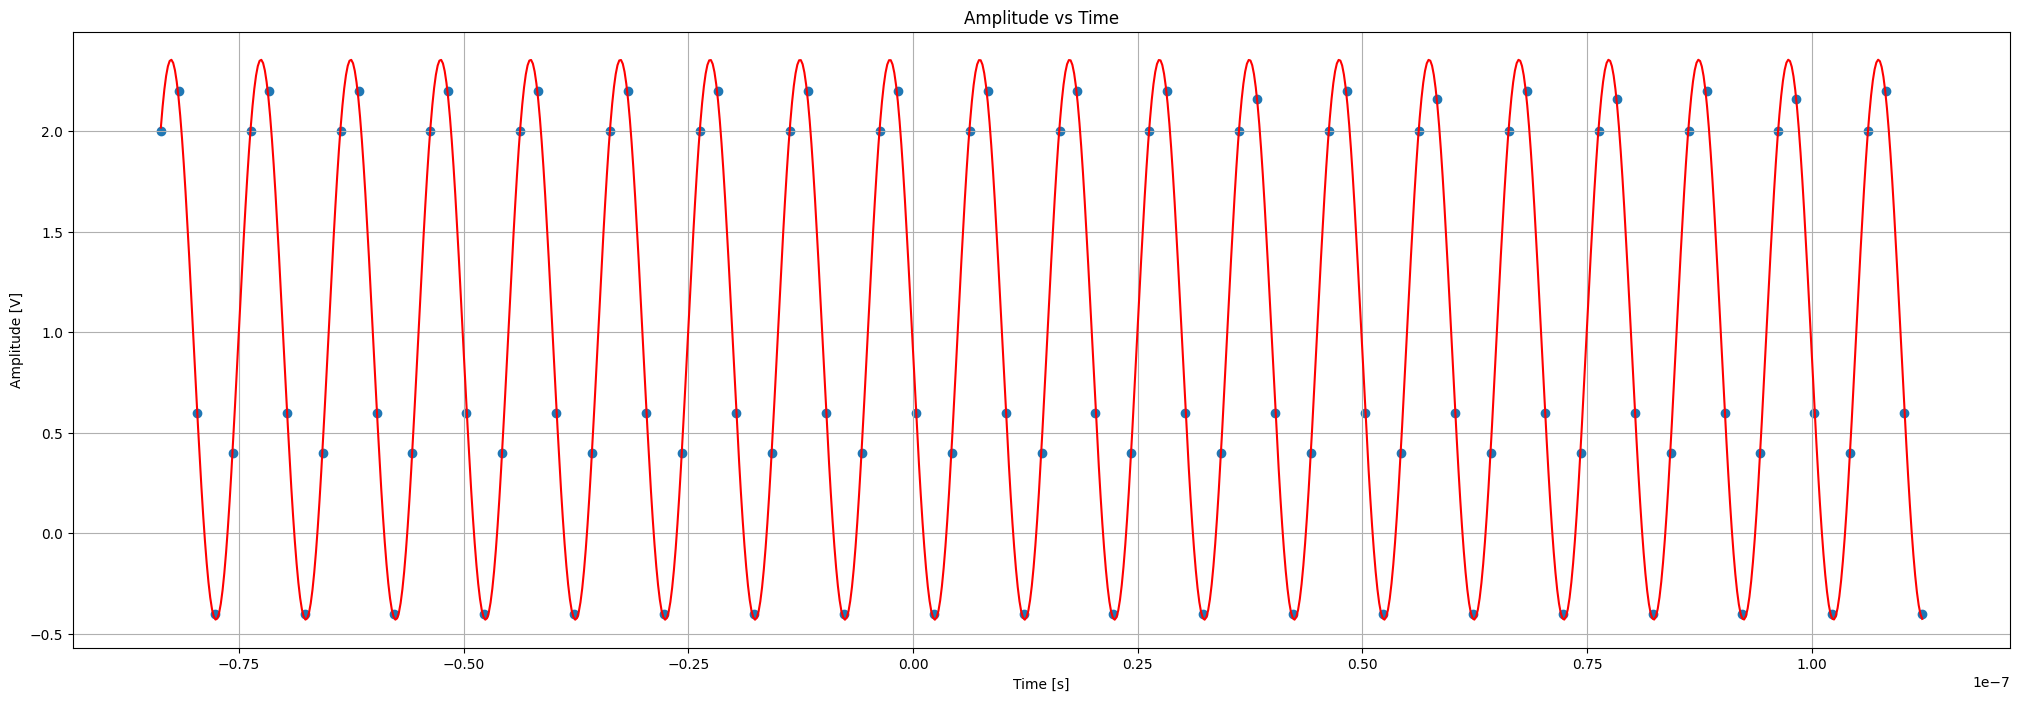

In [19]:
plt.figure(figsize=(25,8))
plt.scatter(tim11,sig11)
plotAmplitudeVsTime(fitrange, fitfunc, 'r')

Summarize the results of the fits

In [20]:
print(f'The clock phase is {phase_clk1:.3f} +/- {err_phase_clk1:.3f}, guess was {clk1_guess:.2f}')
print(f'The signal phase is {phase_sig1:.3f} +/- {err_phase_sig1:.3f}, guess was {sig1_guess:.2f}')
print(f'The frequency is {freq:.5E} +/- {err_freq:.1E}')

The clock phase is 1.100 +/- 0.001, guess was 1.08
The signal phase is 3.097 +/- 0.000, guess was 3.14
The frequency is 1.00008E+08 +/- 8.4E+00


### Determine the total phase difference between the two signals of this run
Note that you have to estimate the current integral multiples of  $2\pi$ to add ("ncycle" below)

Recall that a full cycle is approximabely a 3 meter distance, so if your distance is between 3 and 6 meters then you need a phase difference between $1 \times 2\pi=6.28$ and $2 \times 2\pi=4\pi=12.52$ radians

In [21]:
ncycle=0
phase1=-1*(phase_clk1-phase_sig1)+ncycle*2.0*np.pi
err_1 = np.sqrt(err_phase_sig1**2+err_phase_clk1**2)

print(f'The phase difference for this run is {phase1:.4f} +/- {err_1:.4f} radians')

The phase difference for this run is 1.9971 +/- 0.0010 radians
